## Import Dependencies

In [13]:
# misc
import math
import time
from pathlib import Path

# scientific
import numpy as np
import beatbrain
from beatbrain import utils

# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Tensorflow
import tensorflow as tf

from tensorflow.keras import Model, Sequential, Input, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import (
    Conv1D,
    Conv2D,
    Conv2DTranspose,
    MaxPool1D,
    MaxPool2D,
    Dense,
    Lambda,
    Reshape,
    Flatten,
    Layer,
    concatenate,
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TerminateOnNaN,
    CSVLogger,
    LambdaCallback,
)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [15]:
sns.set()
sns.set_style("white")
%matplotlib inline

In [16]:
# Input
DATA_ROOT = Path("../data/fma/image")
IMAGE_DIMS = [512, 640, 1]
BATCH_SIZE = 16

In [17]:
train_dataset = utils.load_dataset(
    DATA_ROOT / "train", batch_size=BATCH_SIZE, parallel=False
)
val_dataset = utils.load_dataset(
    DATA_ROOT / "val", batch_size=BATCH_SIZE, parallel=False,
)
test_dataset = utils.load_dataset(
    DATA_ROOT / "test", batch_size=1, parallel=False, shuffle_buffer=0,
)

Checking input type(s) in '/home/cds_data/fma/image/train'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/home/cds_data/fma/image/val'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/home/cds_data/fma/image/test'...
Determined input type to be 'IMAGE'


In [18]:
def build_cvae(
    latent_dim,
    input_shape,
    start_filters=512,
    num_conv=3,
    num_inception=3,
    num_deconv=3,
    batch_size=1,
    learning_rate=1e-4,
):
    def reparam(args):
        z_mean, z_log_var = args
        dim = tf.keras.backend.int_shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return eps * tf.exp(z_log_var * 0.5) + z_mean

    encoder_input = Input(shape=input_shape, batch_size=batch_size, name="encoder_input")
    e = Lambda(reshape_1d)(encoder_input)  # (batch_size, time, freq)
    for i in range(num_conv):
        e = Conv1D(
            filters=start_filters // (2 ** i),
            kernel_size=3,
            strides=1,
            padding="SAME",
            activation="relu",
        )(e)
    for i in range(num_inception):
        filters = start_filters // 2 ** (num_conv + i)
        e = Inception1D(filters)(e)
        e = MaxPool1D()(e)
    e = Flatten()(e)
    e = Dense(latent_dim * 2)(e)  # (batch_size, latent_dim*2)
    z_mean = Dense(latent_dim, name="z_mean")(e)
    z_log_var = Dense(latent_dim, name="z_log_var")(e)
    z = Lambda(reparam, output_shape=(latent_dim,), name="z")(
        [z_mean, z_log_var],
    )  # (batch_size, latent_dim)

    decoder_input_shape = [
        batch_size,
        input_shape[1] // 2 ** num_deconv,
        input_shape[0] // 2 ** num_deconv,
    ]  # shape: [?, time, freq]
    decoder_input = Input(shape=(latent_dim,), batch_size=batch_size, name="decoder_input")
    d = Dense(decoder_input_shape[1] * decoder_input_shape[2], activation="relu",)(decoder_input)
    d = Reshape(target_shape=(decoder_input_shape[1], decoder_input_shape[2]))(d)
    for i in range(num_deconv):
        d = Conv1DTranspose(
            filters=input_shape[0] // 2 ** (num_deconv - i),
            kernel_size=3,
            strides=2,
            padding="SAME",
            activation="relu",
        )(d)
    decoder_output = Conv1DTranspose(
        filters=input_shape[0],
        kernel_size=3,
        strides=1,
        padding="SAME",
        activation="sigmoid",  # Changed this from RELU
        name="decoder_output",
    )(d)
    decoder_output = Lambda(reshape_2d)(decoder_output)

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    decoder = Model(decoder_input, decoder_output, name="decoder")
    model_output = decoder(encoder(encoder_input)[2])
    model = Model(encoder_input, model_output, name="vae")

    assert encoder_input.shape == model_output.shape
    reconstruction_loss = tf.losses.mse(encoder_input, model_output)
    reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])  # To exclude channels or not to exclude?
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, z_mean, z_log_var)
    kl_loss = logqz_x - logpz
#     vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae_loss = tf.reduce_mean(reconstruction_loss)

    model.add_loss(vae_loss)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=lambda yt, yp: vae_loss)
    return model, encoder, decoder

class Inception1D(Layer):
    def __init__(self, filters, *args, **kwargs):
        self._filters = filters
        self._args, self._kwargs = args, kwargs
        super().__init__()

    def build(self, input_shape):
        filters = self._filters
        inputs = Input(shape=input_shape[1:])
        conv1 = Conv1D(filters=filters, kernel_size=1, padding="SAME")(inputs)

        conv3 = Conv1D(filters=filters, kernel_size=1, padding="SAME")(inputs)
        conv3 = Conv1D(filters=filters, kernel_size=3, padding="SAME")(conv3)

        conv5 = Conv1D(filters=filters, kernel_size=1, padding="SAME")(inputs)
        conv5 = Conv1D(filters=filters, kernel_size=5, padding="SAME")(conv5)

        pool = MaxPool1D(pool_size=3, strides=1, padding="SAME")(inputs)
        pool = Conv1D(filters=filters, kernel_size=1, padding="SAME")(pool)

        concat = concatenate([conv1, conv3, conv5, pool], axis=-1)
        self._model = Model(inputs, concat)
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
        })
        return config

        
class Conv1DTranspose(Layer):
    def __init__(self, filters, kernel_size, strides=1, *args, **kwargs):
        self._filters = filters
        self._kernel_size = (1, kernel_size)
        self._strides = (1, strides)
        self._args, self._kwargs = args, kwargs
        super(Conv1DTranspose, self).__init__()

    def build(self, input_shape):
        inp = Input(shape=input_shape[1:])
        reshaped = Lambda(lambda x: tf.expand_dims(x, 1), batch_input_shape=input_shape)(inp)
        conv = Conv2DTranspose(
            self._filters,
            kernel_size=self._kernel_size,
            strides=self._strides,
            *self._args,
            **self._kwargs
        )(reshaped)
        output = Lambda(lambda x: x[:, 0])(conv)
        self._model = Model(inputs=inp, outputs=output)
        super(Conv1DTranspose, self).build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "kernel_size": self._kernel_size,
            "strides": self._strides,
        })
        return config


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


@tf.function
def sample(latent_dim, decoder, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, eps, apply_sigmoid=True)


def encode(encoder, x):
    inference = encoder(x)
    mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
    return mean, logvar


def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean


def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits


def reshape_1d(x, axis=-1):
    x = tf.squeeze(x, axis=-1)
    x = tf.transpose(x, [0, 2, 1])
    return x


def reshape_2d(x, axis=-1):
    x = tf.transpose(x, [0, 2, 1])
    x = tf.expand_dims(x, axis=-1)
    return x

## Hyperparameters, Model Output, and Logging

In [19]:
# Hyperparameters
LATENT_DIM = 4096
EPOCHS = 50
NUM_CONV = 3
NUM_INCEPTION = 7
NUM_DECONV = 5
LEARNING_RATE = 1e-5

# Outputs
MODEL_NAME = "cvae_1d_inception"
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)
LOG_DIR = Path("../logs") / MODEL_NAME
LOG_DIR.mkdir(exist_ok=True, parents=True)
LOG_FREQUENCY = 200

## Define Training Callbacks

In [20]:
class VisualizeCallback(Callback):
    def __init__(
        self,
        log_dir,
        latent_dim,
        validation_data,
        n_examples=4,
        random_vectors=None,
        heatmap=True,
        frequency="epoch",
        verbose=False,
    ):
        self.log_dir = Path(log_dir)
        self.latent_dim = latent_dim
        self.n_examples = n_examples
        self.cmap = "magma" if heatmap else "Greys"
        self.frequency = frequency
        self.verbose = verbose
        self.total_batch = 0
        self.random_vectors = random_vectors or tf.random.normal(
            shape=[n_examples, latent_dim]
        )
        self.fig = plt.figure()
        self.samples = list(validation_data.unbatch().take(self.n_examples))

        self.recon_raw = self.log_dir / "raw" / "reconstructed"
        self.recon_png = self.log_dir / "png" / "reconstructed"
        self.gen_raw = self.log_dir / "raw" / "generated"
        self.gen_png = self.log_dir / "png" / "generated"

    def on_train_begin(self, logs=None):
        self.recon_raw.mkdir(exist_ok=True, parents=True)
        self.recon_png.mkdir(exist_ok=True, parents=True)
        self.gen_raw.mkdir(exist_ok=True, parents=True)
        self.gen_png.mkdir(exist_ok=True, parents=True)

    def _visualize_reconstruction(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        fig = plt.figure(self.fig.number)
        fig.set_size_inches(9, 4)
        for i, sample in enumerate(self.samples):
            fig.add_subplot(121)
            sample = sample[None, :]
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(sample[0, ..., 0].numpy()),
                title="Original",
                cmap=self.cmap,
            )
            fig.add_subplot(122)
            reconstructed = self.model(sample)
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(reconstructed[0, ..., 0].numpy()),
                title="Reconstructed",
                cmap=self.cmap,
            )
            fig.tight_layout()
            title = f"recon_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            fig.suptitle(title)
            fig.savefig(self.recon_png / f"{title}.png")
            utils.save_image(
                reconstructed[0, ..., 0], self.recon_raw / f"{title}.exr",
            )
            fig.clear()

    def _visualize_generation(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        decoder = self.model.get_layer("decoder")
        generated = decoder(self.random_vectors)
        fig = plt.figure(self.fig.number)
        fig.set_size_inches(5, 4)
        for i, gen in enumerate(generated):
            gen = gen[None, :]
            title = f"gen_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(gen[0, ..., 0].numpy()),
                title=title,
                cmap=self.cmap,
            )
            fig.tight_layout()
            fig.savefig(self.gen_png / f"{title}.png")
            utils.save_image(gen[0, ..., 0], self.gen_raw / f"{title}.exr")
            fig.clear()

    def on_epoch_begin(self, epoch, logs=None):
        if self.frequency == "epoch":
            self._visualize_reconstruction(epoch=epoch)
            self._visualize_generation(epoch=epoch)

    def on_train_batch_begin(self, batch, logs=None):
        if isinstance(self.frequency, int) and (self.total_batch % self.frequency == 0):
            self._visualize_reconstruction(batch=self.total_batch)
            self._visualize_generation(batch=self.total_batch)

    def on_train_batch_end(self, batch, logs=None):
        self.total_batch += 1

In [21]:
tensorboard = TensorBoard(log_dir=LOG_DIR, update_freq=LOG_FREQUENCY, profile_batch=0,)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.1, min_lr=1e-6, verbose=1,)
early_stop = EarlyStopping(patience=5, verbose=1,)
model_saver = ModelCheckpoint(
    str(MODEL_DIR / MODEL_NAME), save_best_only=True, verbose=1,
)
visualizer = VisualizeCallback(
    LOG_DIR, LATENT_DIM, val_dataset, frequency=LOG_FREQUENCY,
)

<Figure size 432x288 with 0 Axes>

## Instantiate and Train Model

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(16, 512, 640, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(16, 4096), (16, 40 110464544   encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (16, 512, 640, 1)    21505984    encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_SquaredDifference_1 [(16, 512, 640, 1)]  0           decoder[1][0]                    
                                                                 encoder_input[0][0]            

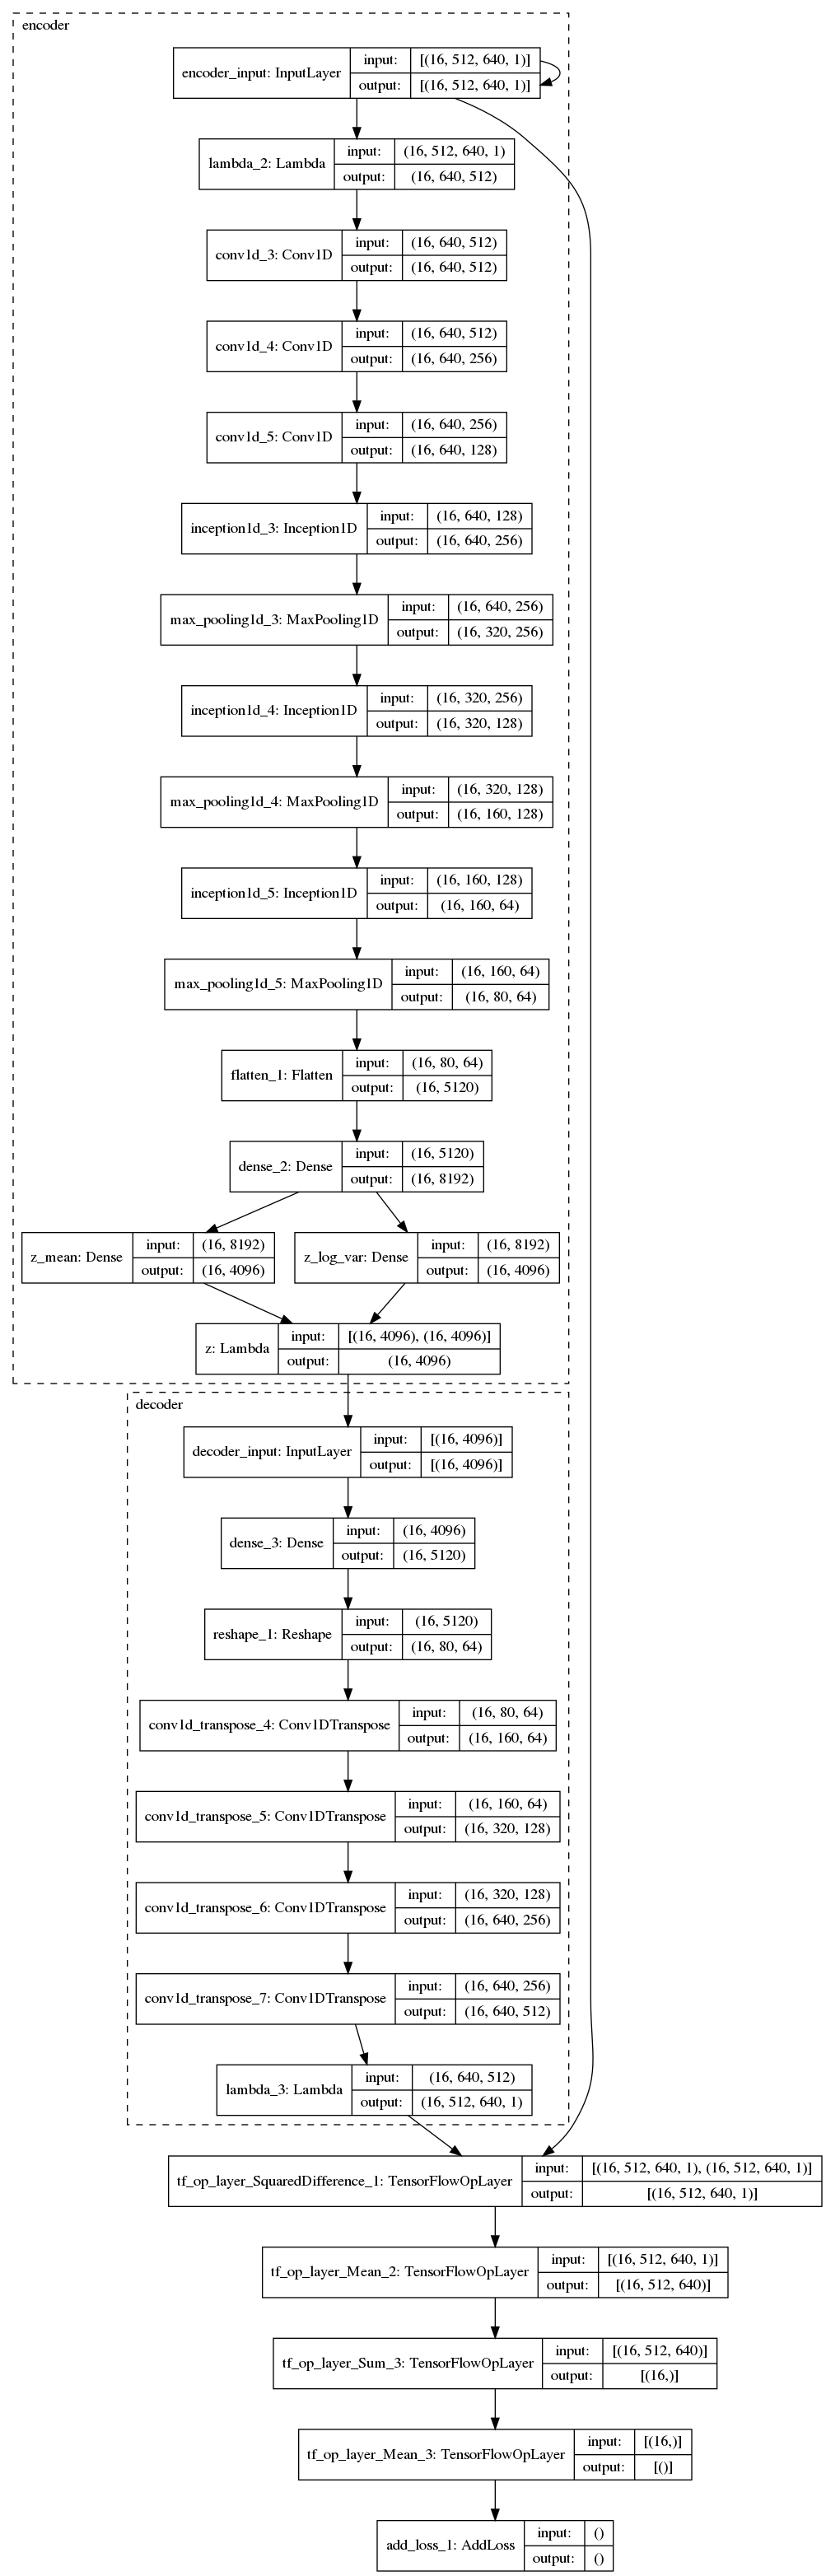

In [22]:
model, encoder, decoder = build_cvae(
    LATENT_DIM,
    IMAGE_DIMS,
    num_conv=NUM_CONV,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
)
model.summary()
encoder.summary()
decoder.summary()
plot_model(model, to_file=str(LOG_DIR / "model.png"), expand_nested=True, show_shapes=True)

In [ ]:
model.fit_generator(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[tensorboard, model_saver, reduce_lr, visualizer,],
    validation_data=val_dataset,
)

Epoch 1/50
2403/2404 [============================>.] - ETA: 0s - loss: 6338.1707
Epoch 00001: val_loss improved from inf to 4007.70711, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 641s 267ms/step - loss: 6337.1819 - val_loss: 4007.7071
Epoch 2/50
2403/2404 [============================>.] - ETA: 0s - loss: 3727.8177
Epoch 00002: val_loss improved from 4007.70711 to 3555.60406, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 638s 265ms/step - loss: 3727.6558 - val_loss: 3555.6041
Epoch 3/50
2403/2404 [============================>.] - ETA: 0s - loss: 3404.6525
Epoch 00003: val_loss improved from 3555.60406 to 3309.12623, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2471.4194
Epoch 00013: val_loss improved from 2565.51448 to 2545.95932, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 640s 266ms/step - loss: 2471.3773 - val_loss: 2545.9593
Epoch 14/50
2403/2404 [============================>.] - ETA: 0s - loss: 2451.5446
Epoch 00014: val_loss improved from 2545.95932 to 2527.68724, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 638s 265ms/step - loss: 2451.7457 - val_loss: 2527.6872
Epoch 15/50
  60/2404 [..............................] - ETA: 9:05 - loss: 2421.7030

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2342.6769
Epoch 00020: val_loss improved from 2450.92383 to 2421.35792, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 641s 267ms/step - loss: 2342.7402 - val_loss: 2421.3579
Epoch 21/50
 924/2404 [==========>...................] - ETA: 6:06 - loss: 2336.7612

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2236.6410
Epoch 00026: val_loss improved from 2337.23531 to 2315.02654, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 650s 270ms/step - loss: 2236.6983 - val_loss: 2315.0265
Epoch 27/50
1598/2404 [==================>...........] - ETA: 3:20 - loss: 2224.8340

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2156.5508
Epoch 00032: val_loss improved from 2254.86101 to 2243.99927, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 645s 268ms/step - loss: 2156.5431 - val_loss: 2243.9993
Epoch 33/50
1979/2404 [=======================>......] - ETA: 1:45 - loss: 2148.5048

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2095.4883
Epoch 00039: val_loss improved from 2197.21705 to 2189.60057, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 645s 268ms/step - loss: 2095.4877 - val_loss: 2189.6006
Epoch 40/50
 736/2404 [========>.....................] - ETA: 6:55 - loss: 2078.4592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2403/2404 [============================>.] - ETA: 0s - loss: 2041.7961
Epoch 00045: val_loss improved from 2140.55350 to 2127.61929, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 650s 270ms/step - loss: 2041.7514 - val_loss: 2127.6193
Epoch 46/50
2403/2404 [============================>.] - ETA: 0s - loss: 2031.3400
Epoch 00046: val_loss improved from 2127.61929 to 2113.20577, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [==============================] - 647s 269ms/step - loss: 2031.2790 - val_loss: 2113.2058
Epoch 47/50
2403/2404 [============================>.] - ETA: 0s - loss: 2019.7758
Epoch 00047: val_loss improved from 2113.20577 to 2106.02646, saving model to ../models/cvae_1d_inception
INFO:tensorflow:Assets written to: ../models/cvae_1d_inception/assets
2404/2404 [======================